# 1P - Track Features

In [1]:
from os import path

import numpy as np
import h5py
from tqdm import tqdm

%matplotlib inline
from rnn_tauid.common.mpl_setup import mpl_setup
import matplotlib.pyplot as plt
mpl_setup()

Input files and datasets:

In [2]:
# Sample paths
sig_jet_fname = "C:\\Users\\chris\\Desktop\\rnn-samples-v4\\sig1P_jet.h5"
bkg_jet_fname = "C:\\Users\\chris\\Desktop\\rnn-samples-v4\\bkg1P_jet_shuffle.h5"
sig_track_fname = "C:\\Users\\chris\\Desktop\\rnn-samples-v4\\sig1P_track.h5"
bkg_track_fname = "C:\\Users\\chris\\Desktop\\rnn-samples-v4\\bkg1P_track_shuffle.h5"

# Output sample
outf_fname = "C:\\Users\\chris\\Desktop\\ololol_outfile.h5"

# Plot output prefix
plot_prefix = "C:\\Users\\chris\\Desktop\\plots"

In [3]:
# Tau-level datasets
sigf_jet = h5py.File(sig_jet_fname, "r")
bkgf_jet = h5py.File(bkg_jet_fname, "r")
sig_jet = sigf_jet["jet"]
bkg_jet = bkgf_jet["jet"]

# Track-level datasets
sigf_track = h5py.File(sig_track_fname, "r")
bkgf_track = h5py.File(bkg_track_fname, "r")
sig_track = sigf_track["track"]
bkg_track = bkgf_track["track"]

Sample fractions for training/validation

In [4]:
# Fraction of the smallest sample to be used for training and validation
total_frac = 0.2
idx = int(total_frac * min(len(sig_track), len(bkg_track)))
# Number of tracks to save
n_tracks = 10

print("[0:{}] for RNN-training".format(idx))

[0:1308853] for RNN-training


## $p_\mathrm{T}$-reweighting

### Before reweighting

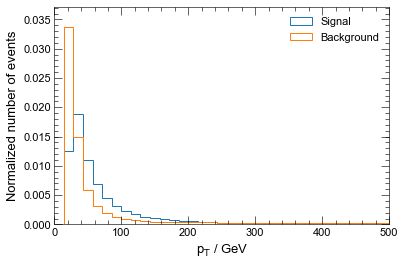

In [5]:
sig_pt = sig_jet[:idx, "TauJets.pt"]
bkg_pt = bkg_jet[:idx, "TauJets.pt"]

plt.hist(sig_pt / 1000.0, bins=35, range=(0, 500), histtype="step", normed=True, label="Signal")
plt.hist(bkg_pt / 1000.0, bins=35, range=(0, 500), histtype="step", normed=True, label="Background")
plt.legend()
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi))
plt.xlabel("$p_\mathrm{T}$ / GeV")
plt.ylabel("Normalized number of events")
plt.savefig(path.join(plot_prefix, "pt_no_reweight_1p.pdf"))

In [6]:
# Binning
bin_edges = np.percentile(bkg_pt, np.linspace(0.0, 100.0, 50))
bin_edges[0] = 20000.0 # 20 GeV lower limit
bin_edges[-1] = 4000000.0 # 4000 GeV upper limit
midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2.0

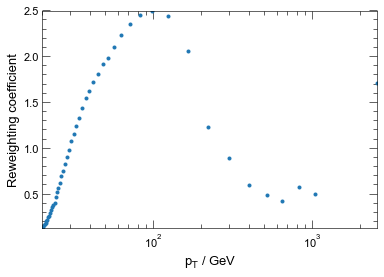

In [7]:
# Reweighting coefficient
sig_hist, _ = np.histogram(sig_pt, bins=bin_edges, density=True)
bkg_hist, _ = np.histogram(bkg_pt, bins=bin_edges, density=True)

coeff = sig_hist / bkg_hist

plt.plot(midpoints / 1000.0, coeff, ".")
plt.xlabel("$p_\mathrm{T}$ / GeV")
plt.ylabel("Reweighting coefficient")
plt.xscale("log")
plt.savefig(path.join(plot_prefix, "pt_reweight_coeff_1p.pdf"))

In [8]:
# Apply reweighting
sig_weight = np.ones_like(sig_pt)
bkg_weight = coeff[np.digitize(bkg_pt, bin_edges) - 1].astype(np.float32)

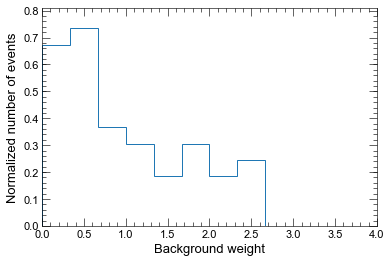

In [9]:
plt.hist(bkg_weight, bins=12, range=(0.0, 4.0), histtype="step", normed=True)
plt.xlabel("Background weight")
plt.ylabel("Normalized number of events")
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi));
plt.savefig(path.join(plot_prefix, "background_weights_1p.pdf"))

### After reweighting

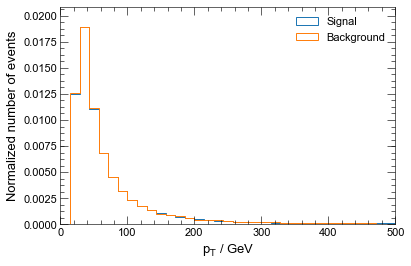

In [10]:
plt.hist(sig_pt / 1000.0, weights=sig_weight, bins=35, range=(0, 500), histtype="step", normed=True, label="Signal")
plt.hist(bkg_pt / 1000.0, weights=bkg_weight, bins=35, range=(0, 500), histtype="step", normed=True, label="Background")
plt.legend()
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi))
plt.xlabel("$p_\mathrm{T}$ / GeV")
plt.ylabel("Normalized number of events")
plt.savefig(path.join(plot_prefix, "pt_reweight_1p.pdf"))

## Create output file

### Variables from input samples

In [11]:
jet_vars = ["TauJets.pt", "TauJets.eta", "TauJets.mu", "TauJets.nVtxPU"]

In [12]:
var_names = ["TauTracks.qOverP", "TauTracks.z0sinThetaTJVA", "TauTracks.d0",
             "TauTracks.dRJetSeedAxis", "TauTracks.rConvII", "TauTracks.nInnermostPixelHits",
             "TauTracks.nPixelHits", "TauTracks.nSiHits", "TauTracks.eProbabilityHT"]

In [13]:
h5opt = dict(dtype=np.float32, compression="gzip", compression_opts=9, shuffle=True, fletcher32=True)

outf = h5py.File(outf_fname, "w")

outf.attrs["idx"] = idx
outf.create_dataset("label", (2 * idx,), **h5opt)
outf.create_dataset("weight", (2 * idx,), **h5opt)

# First idx values signal, rest background
outf["label"][:idx] = 1
outf["label"][idx:] = 0
outf["weight"][:idx] = sig_weight
outf["weight"][idx:] = bkg_weight

In [14]:
for var in tqdm(jet_vars):
    ds = outf.create_dataset("data/" + var, (2 * idx,), **h5opt)
    ds[:idx] = sig_jet[:idx, var]
    ds[idx:] = bkg_jet[:idx, var]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.07s/it]


In [15]:
for var in tqdm(var_names):
    ds = outf.create_dataset("data/" + var, (2 * idx, n_tracks), **h5opt)
    ds[:idx] = sig_track[:idx, :n_tracks, var]
    ds[idx:] = bkg_track[:idx, :n_tracks, var]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [09:07<00:00, 69.69s/it]


### Calculated variables

In [16]:
sig_pt_track = sig_track[:idx, :n_tracks, "TauTracks.pt"]
bkg_pt_track = bkg_track[:idx, :n_tracks, "TauTracks.pt"]

sig_pt_jet = sig_jet[:idx, "TauJets.ptJetSeed"][:, np.newaxis]
bkg_pt_jet = bkg_jet[:idx, "TauJets.ptJetSeed"][:, np.newaxis]

outf.create_dataset("data/TauTracks.ptfrac", (2 * idx, n_tracks), **h5opt)
outf["data/TauTracks.ptfrac"][:idx] = np.clip(sig_pt_track / sig_pt_jet, 0.0, 1.5)
outf["data/TauTracks.ptfrac"][idx:] = np.clip(bkg_pt_track / bkg_pt_jet, 0.0, 1.5)

del sig_pt_track, bkg_pt_track
del sig_pt_jet, bkg_pt_jet

## Monitoring plots

In [17]:
sig_mask = outf["label"][...] == 1
bkg_mask = ~sig_mask

### TauJets

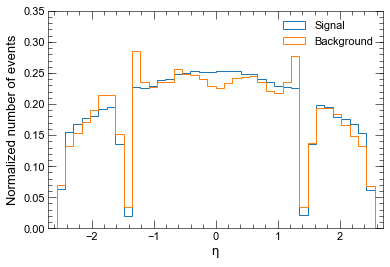

In [18]:
histopt = dict(bins=40, range=(-2.7, 2.7), normed=True, histtype="step")
plt.hist(outf["data/TauJets.eta"][sig_mask], label="Signal", **histopt)
plt.hist(outf["data/TauJets.eta"][bkg_mask], weights=bkg_weight, label="Background", **histopt)
plt.xlabel("$\eta$")
plt.ylabel("Normalized number of events")
plt.ylim((0.0, 0.35))
plt.legend()
plt.savefig(path.join(plot_prefix, "jet_eta_1p.pdf"))

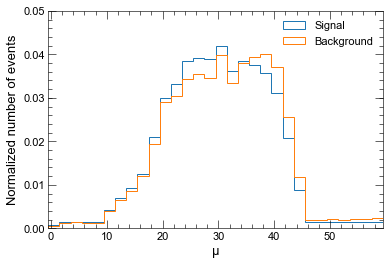

In [19]:
histopt = dict(bins=np.arange(0, 62, 2)-0.5, normed=True, histtype="step")
plt.hist(outf["data/TauJets.mu"][sig_mask], label="Signal", **histopt)
plt.hist(outf["data/TauJets.mu"][bkg_mask], weights=bkg_weight, label="Background", **histopt)
plt.xlabel("$\mu$")
plt.ylabel("Normalized number of events")
plt.ylim((0.0, 0.05))
plt.legend()
plt.savefig(path.join(plot_prefix, "jet_mu_1p.pdf"))

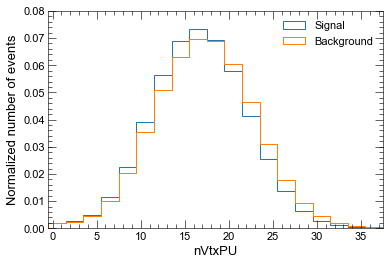

In [20]:
histopt = dict(bins=np.arange(0, 40, 2)-0.5, normed=True, histtype="step")
plt.hist(outf["data/TauJets.nVtxPU"][sig_mask], label="Signal", **histopt)
plt.hist(outf["data/TauJets.nVtxPU"][bkg_mask], weights=bkg_weight, label="Background", **histopt)
plt.xlabel("nVtxPU")
plt.ylabel("Normalized number of events")
plt.ylim((0.0, 0.08))
plt.legend()
plt.savefig(path.join(plot_prefix, "jet_nVtxPU_1p.pdf"))

### TauTracks

In [31]:
def track_plot(var, xlabel="", **histopt):
    arr = outf["data/" + var][:, :n_tracks]

    fig, ax = plt.subplots(n_tracks // 2, 2, sharex=True, figsize=(12.0, 12.0 / 2.0 * (n_tracks // 2) * 3.0 / 4.0))
    ax_flat = ax.ravel()
    
    for i in range(n_tracks):
        s = arr[:, i][sig_mask]
        s = s[~np.isnan(s)]
        
        b = arr[:, i][bkg_mask]
        w = bkg_weight[~np.isnan(b)]
        b = b[~np.isnan(b)]
        
        ax_flat[i].hist(s, label="Signal", **histopt)
        ax_flat[i].hist(b, weights=w, label="Background", **histopt)
        ax_flat[i].annotate(str(i + 1) + ". in $p_\mathrm{T}$", xy=(0.05, 0.9), xycoords="axes fraction")
        
        bottom, top = ax_flat[i].get_ylim()
        ax_flat[i].set_ylim((bottom, 1.1 * top))
    
    ax[0,1].legend(loc="upper right")
    ax[n_tracks // 2 - 1, 0].set_xlabel(xlabel)
    ax[n_tracks // 2 - n_tracks % 2 - 1, 1].set_xlabel(xlabel)
    #ax[0,0].set_ylabel("Normalized number of tracks")
    #ax[1,0].set_ylabel("Normalized number of tracks")
    
    fig.subplots_adjust(hspace=0.05, wspace=0.15)
    
    return fig, ax

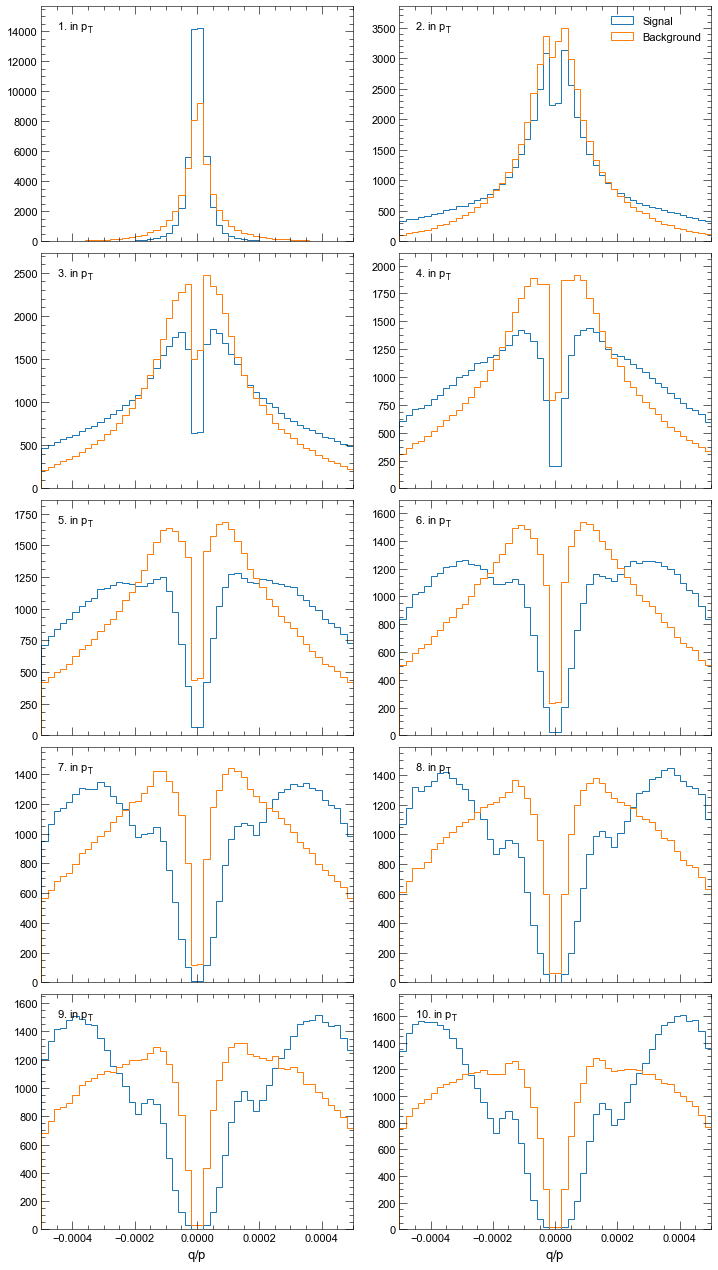

In [32]:
histopt = dict(bins=50, range=(-0.0005, 0.0005), normed=True, histtype="step")
fig, ax = track_plot("TauTracks.qOverP", xlabel="$q / p$", **histopt)
fig.savefig(path.join(plot_prefix, "track_qOverP_1p.pdf"))

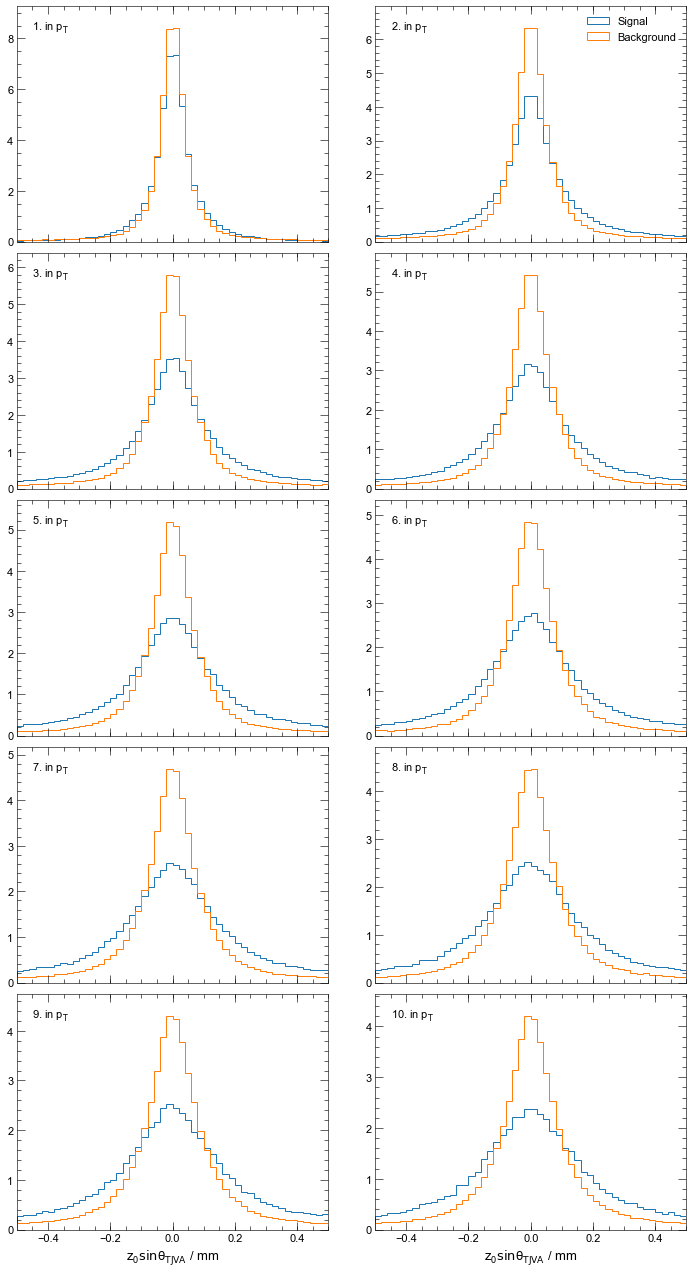

In [33]:
histopt = dict(bins=50, range=(-0.5, 0.5), normed=True, histtype="step")
fig, ax = track_plot("TauTracks.z0sinThetaTJVA", xlabel=r"$z_0 \sin{\theta_\mathrm{TJVA}}$ / mm", **histopt)
fig.savefig(path.join(plot_prefix, "track_z0sinThetaTJVA_1p.pdf"))

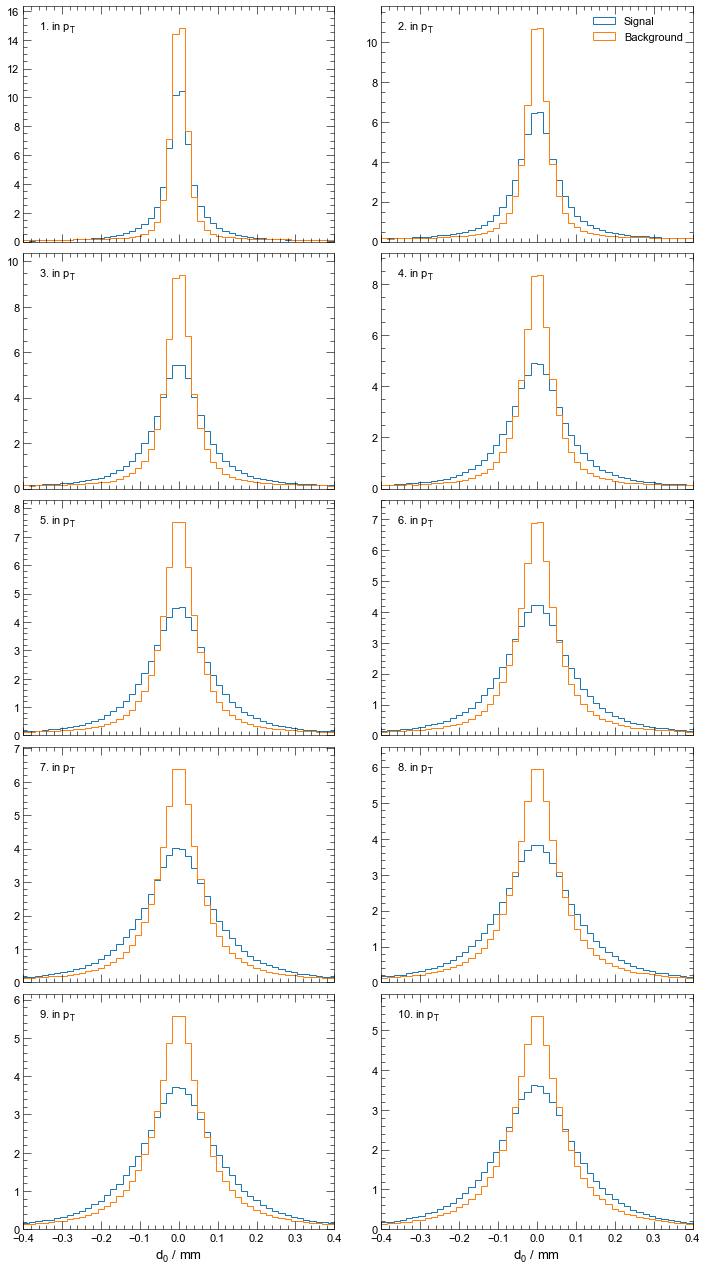

In [34]:
histopt = dict(bins=50, range=(-0.4, 0.4), normed=True, histtype="step")
fig, ax = track_plot("TauTracks.d0", xlabel=r"$d_0$ / mm", **histopt)
fig.savefig(path.join(plot_prefix, "track_d0_1p.pdf"))

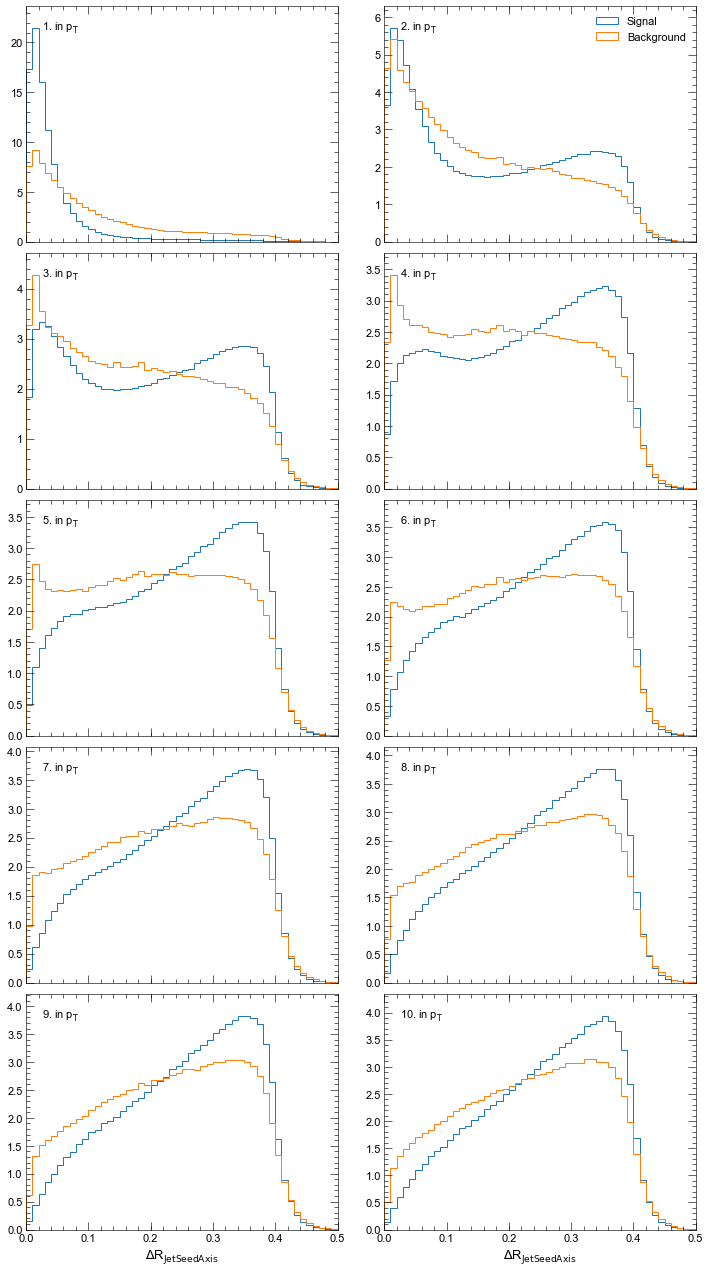

In [35]:
histopt = dict(bins=50, range=(0.0, 0.5), normed=True, histtype="step")
fig, ax = track_plot("TauTracks.dRJetSeedAxis", xlabel=r"$\Delta R_\mathrm{JetSeedAxis}$", **histopt)
fig.savefig(path.join(plot_prefix, "track_dRJetSeedAxis_1p.pdf"))

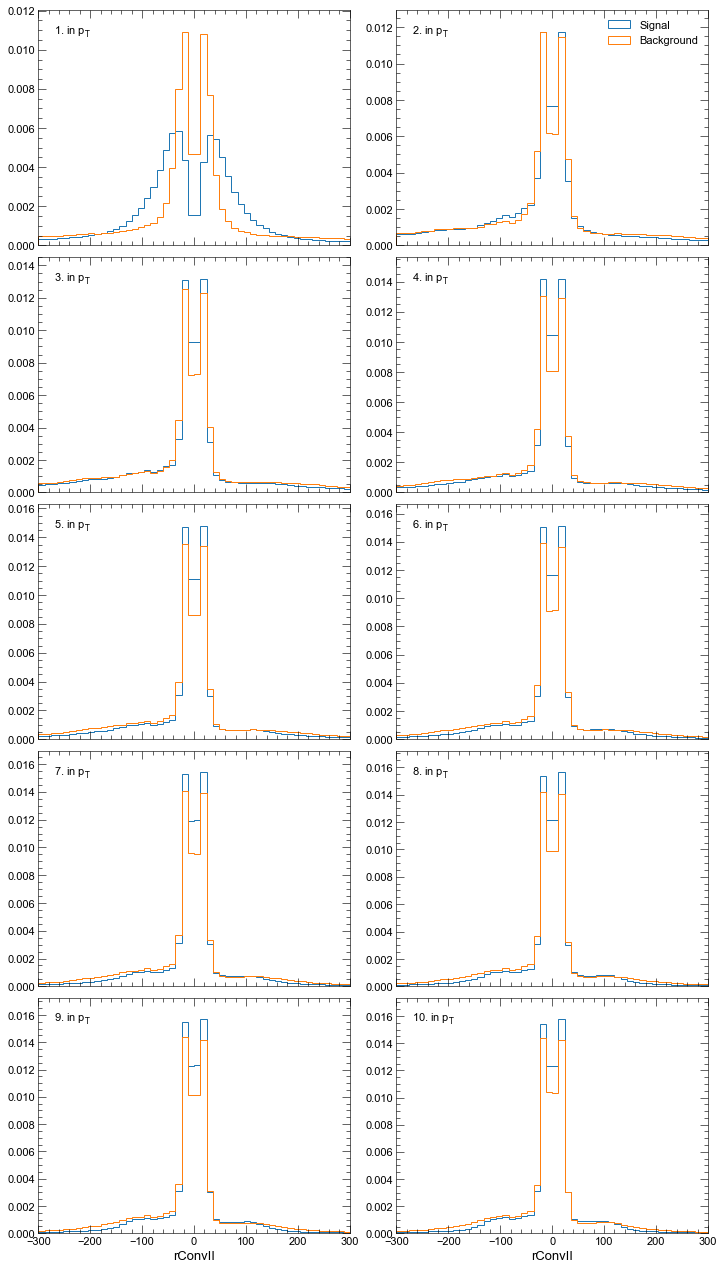

In [36]:
histopt = dict(bins=50, range=(-300.0, 300.0), normed=True, histtype="step")
fig, ax = track_plot("TauTracks.rConvII", xlabel="rConvII", **histopt)
fig.savefig(path.join(plot_prefix, "track_rConvII_1p.pdf"))

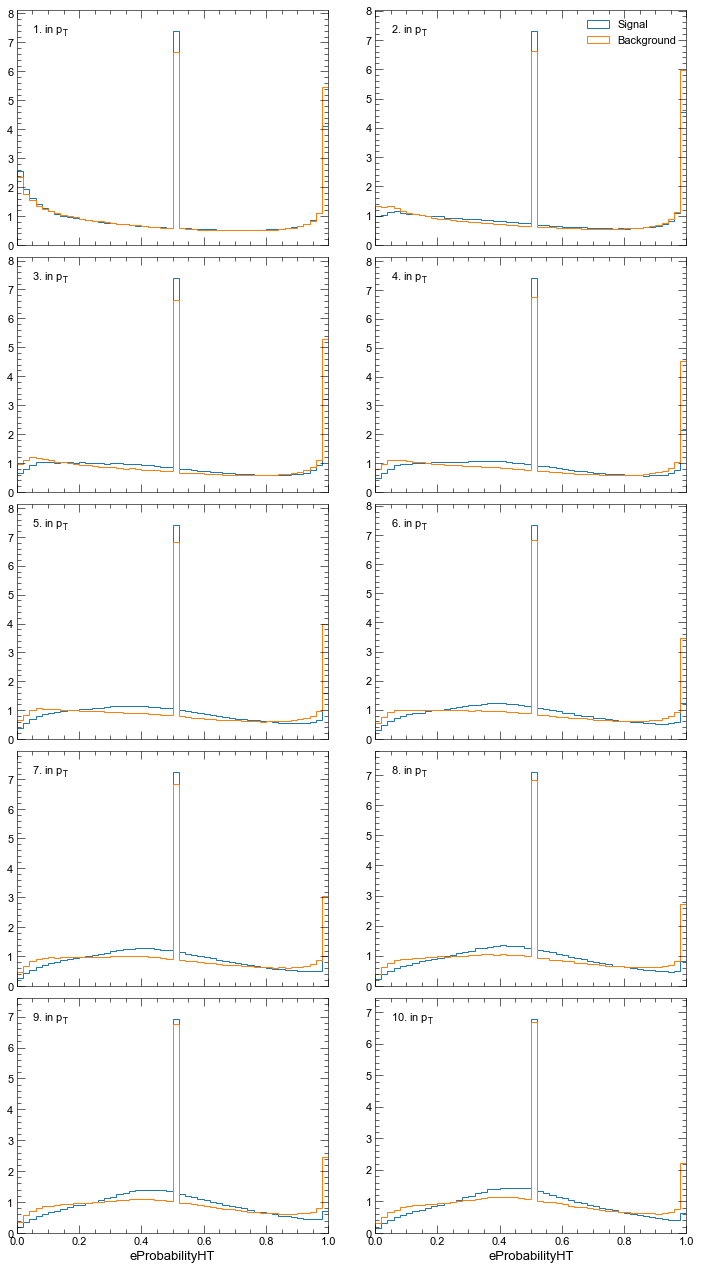

In [37]:
histopt = dict(bins=50, range=(0, 1), normed=True, histtype="step")
fig, ax = track_plot("TauTracks.eProbabilityHT", xlabel="eProbabilityHT", **histopt)
fig.savefig(path.join(plot_prefix, "track_eProbabilityHT_1p.pdf"))

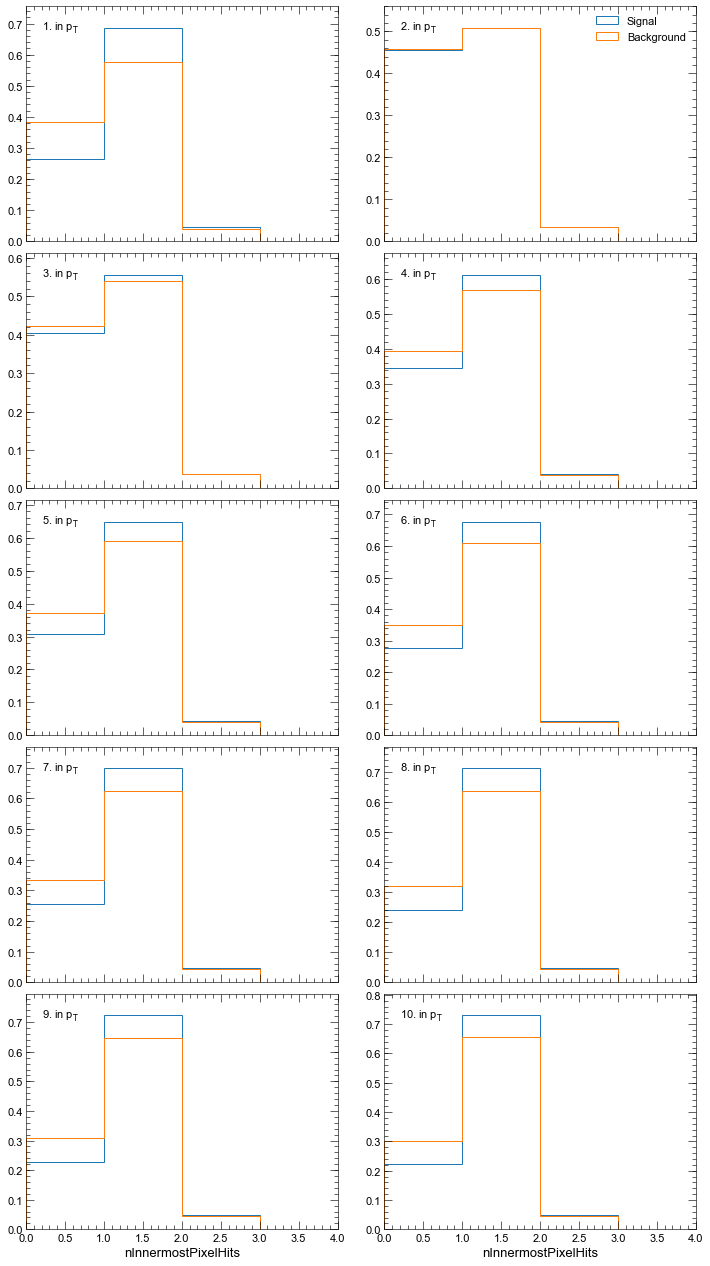

In [38]:
histopt = dict(bins=4, range=(0, 4), normed=True, histtype="step")
fig, ax = track_plot("TauTracks.nInnermostPixelHits", xlabel="nInnermostPixelHits", **histopt)
fig.savefig(path.join(plot_prefix, "track_nInnermostPixelHits_1p.pdf"))

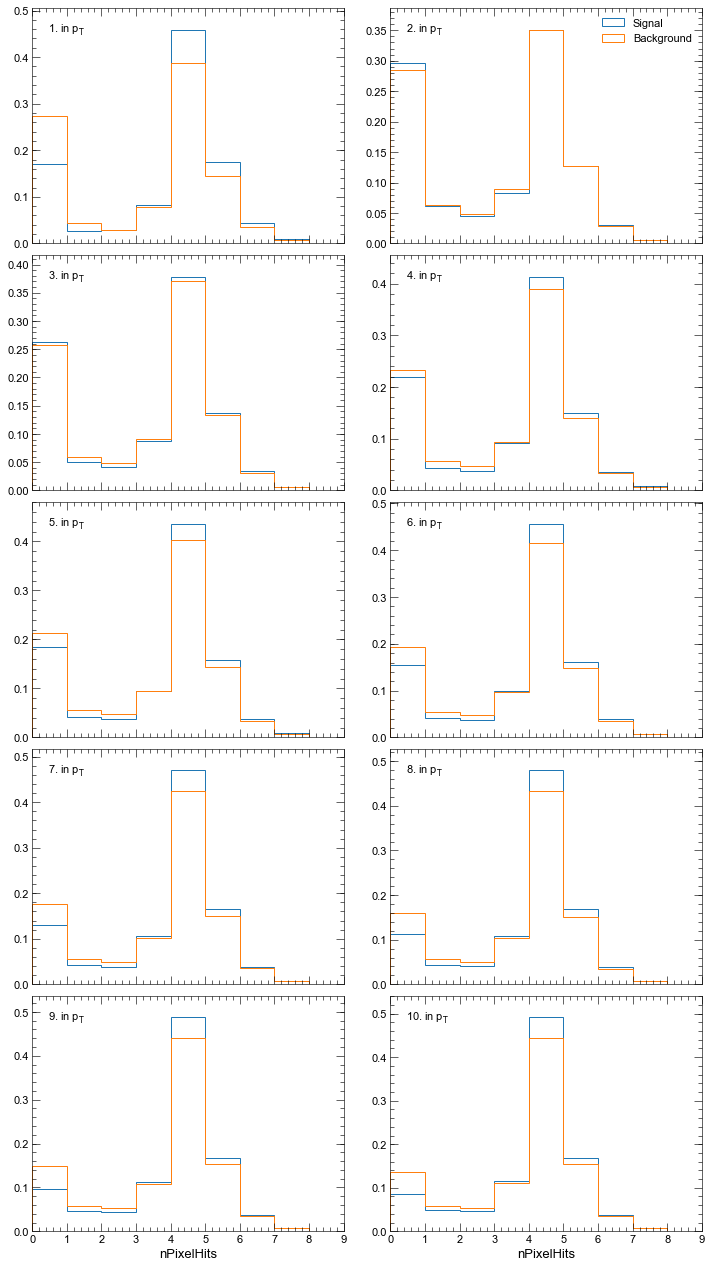

In [39]:
histopt = dict(bins=9, range=(0, 9), normed=True, histtype="step")
fig, ax = track_plot("TauTracks.nPixelHits", xlabel="nPixelHits", **histopt)
fig.savefig(path.join(plot_prefix, "track_nPixelHits_1p.pdf"))

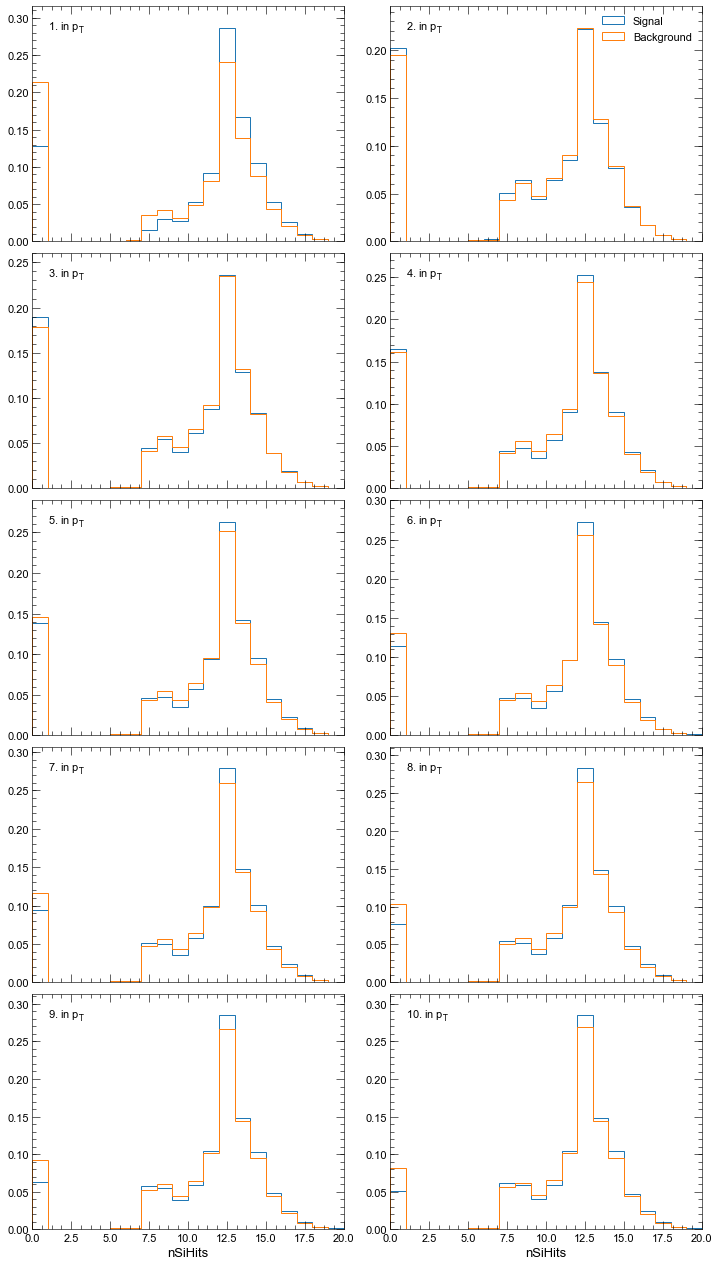

In [40]:
histopt = dict(bins=20, range=(0, 20), normed=True, histtype="step")
fig, ax = track_plot("TauTracks.nSiHits", xlabel="nSiHits", **histopt)
fig.savefig(path.join(plot_prefix, "track_nSiHits_1p.pdf"))

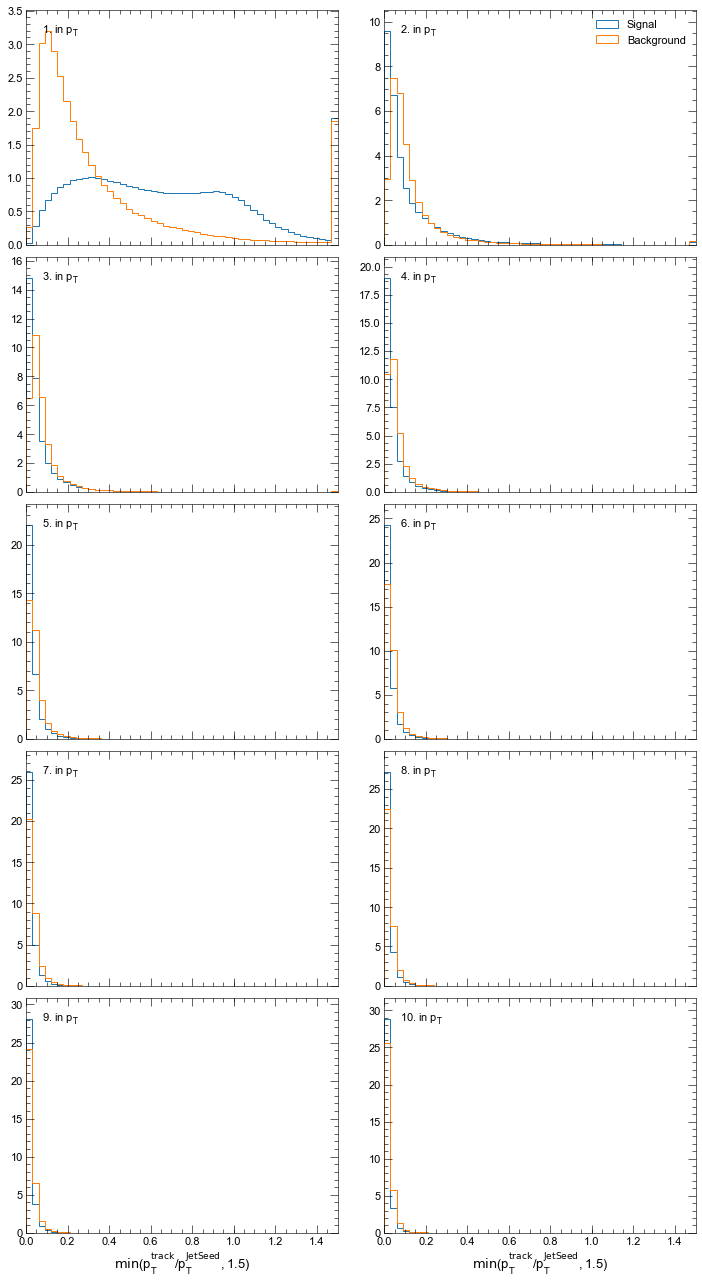

In [41]:
histopt = dict(bins=50, range=(0, 1.5), normed=True, histtype="step")
fig, ax = track_plot("TauTracks.ptfrac",
                     xlabel=r"$\min(p_\mathrm{T}^\mathrm{track} / p_\mathrm{T}^\mathrm{JetSeed}, 1.5)$",
                     **histopt)
fig.savefig(path.join(plot_prefix, "track_nSiHits_1p.pdf"))

## Cleanup

In [42]:
sigf_jet.close()
bkgf_jet.close()
sigf_track.close()
bkgf_track.close()
outf.close()